<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.3+ KB
            brand                                              title  \
0            Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1         AS SHOW  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2       Unbranded                   HOGO BOSS col

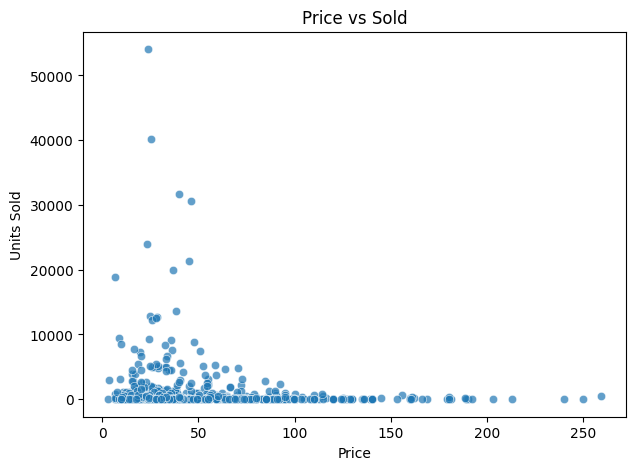

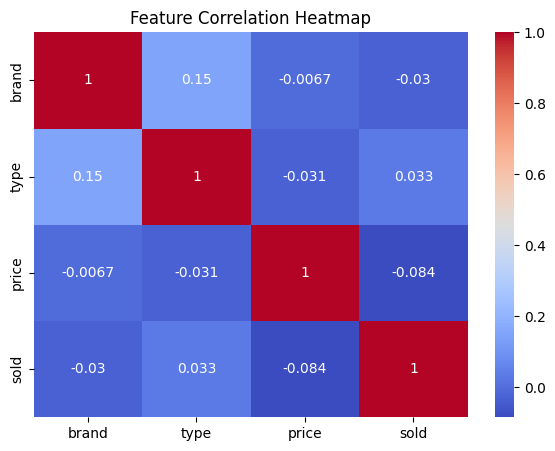

K-Means clusters: 4
K-Means - Silhouette: 0.3492110813852291
K-Means - Davies-Bouldin: 0.9685674503047463
Agglomerative - Silhouette: 0.3350313941698129
Agglomerative - Davies-Bouldin: 1.03010288771659
DBSCAN clusters (excluding noise): 2
DBSCAN - Silhouette: 0.3939267334755363
DBSCAN - Davies-Bouldin: 0.5576282718186496


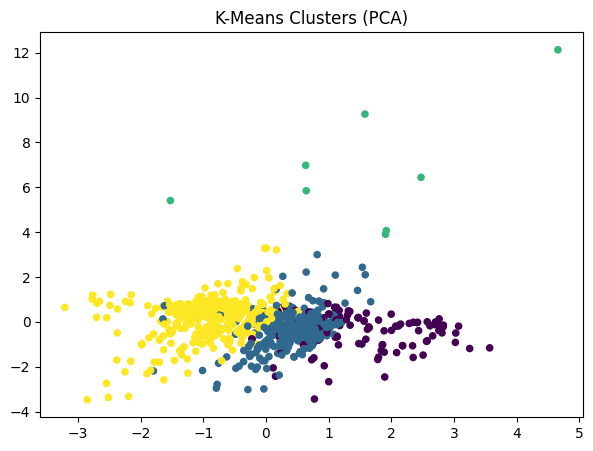

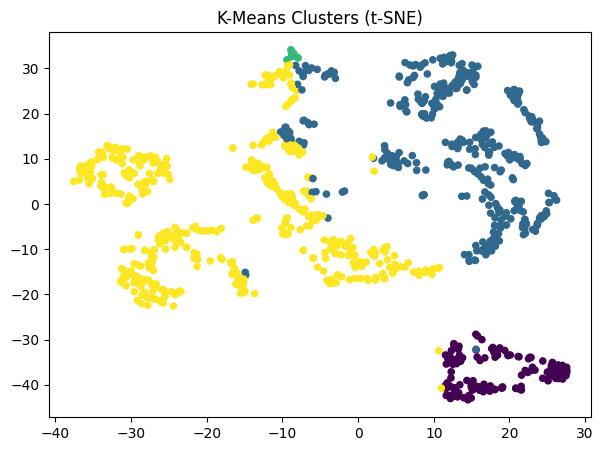

Saved /content/Fragrance_Clustered.csv successfully


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

data = pd.read_csv('/content/Fragrance Dataset.csv')

data.info()
print(data.head())

if 'price' in data.columns:
    data['price'] = pd.to_numeric(data['price'], errors='coerce')
if 'sold' in data.columns:
    data['sold'] = pd.to_numeric(data['sold'], errors='coerce')
if 'available' in data.columns:
    data['available'] = pd.to_numeric(data['available'], errors='coerce')

num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].apply(lambda x: x.fillna(x.median()))

label_encoders = {}
for col in ['brand', 'title', 'type', 'itemLocation']:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

features = [c for c in ['brand', 'type', 'price', 'sold'] if c in data.columns]
X = data[features].copy()

X = X.dropna()

plt.figure(figsize=(7,5))
sns.scatterplot(x='price', y='sold', data=data, alpha=0.7)
plt.title('Price vs Sold')
plt.xlabel('Price')
plt.ylabel('Units Sold')
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
print('K-Means clusters:', len(set(kmeans_labels)))

print('K-Means - Silhouette:', silhouette_score(X_scaled, kmeans_labels))
print('K-Means - Davies-Bouldin:', davies_bouldin_score(X_scaled, kmeans_labels))

agg = AgglomerativeClustering(n_clusters=4)
agg_labels = agg.fit_predict(X_scaled)
print('Agglomerative - Silhouette:', silhouette_score(X_scaled, agg_labels))
print('Agglomerative - Davies-Bouldin:', davies_bouldin_score(X_scaled, agg_labels))

dbscan = DBSCAN(eps=1.2, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_scaled)
n_db_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print('DBSCAN clusters (excluding noise):', n_db_clusters)

if n_db_clusters > 1:
    mask = dbscan_labels != -1
    print('DBSCAN - Silhouette:', silhouette_score(X_scaled[mask], dbscan_labels[mask]))
    print('DBSCAN - Davies-Bouldin:', davies_bouldin_score(X_scaled[mask], dbscan_labels[mask]))

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(pca_data[:,0], pca_data[:,1], c=kmeans_labels, s=20)
plt.title('K-Means Clusters (PCA)')
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=kmeans_labels, s=20)
plt.title('K-Means Clusters (t-SNE)')
plt.show()

data.loc[X.index, 'Cluster'] = kmeans_labels
data.to_csv('/content/Fragrance_Clustered.csv', index=False)
print('Saved /content/Fragrance_Clustered.csv successfully')


,Model,Silhouette Score,Davies-Bouldin Index
0,K-Means,0.349211,0.968567
1,Agglomerative,0.335031,1.030103
2,DBSCAN,0.393927,0.557628


,price,sold,available,Count
Cluster,,,,
0.0,44.94,105.90,7.32,129
1.0,46.02,624.97,22.82,381
2.0,30.91,30086.75,9.88,8
3.0,47.46,559.12,19.11,482


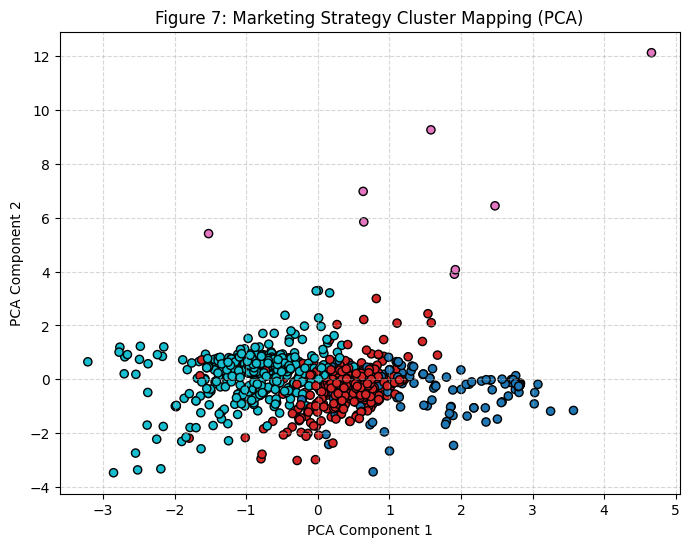

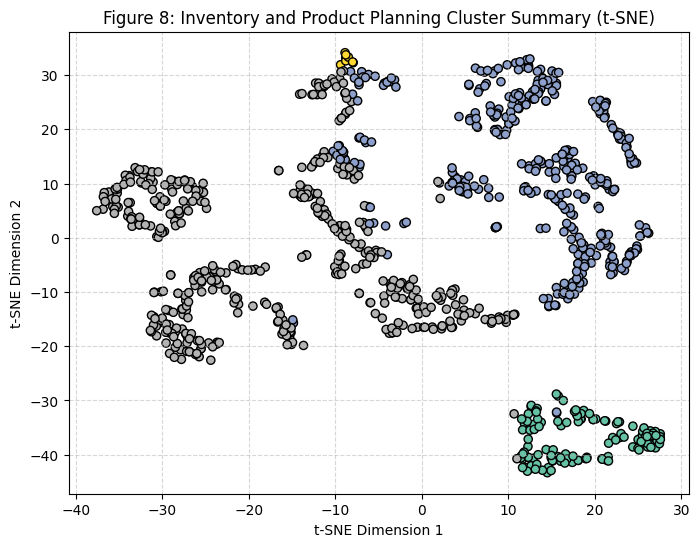

In [10]:
metrics_data = {
    'Model': ['K-Means', 'Agglomerative', 'DBSCAN'],
    'Silhouette Score': [
        silhouette_score(X_scaled, kmeans_labels),
        silhouette_score(X_scaled, agg_labels),
        silhouette_score(X_scaled[mask], dbscan_labels[mask]) if n_db_clusters > 1 else np.nan
    ],
    'Davies-Bouldin Index': [
        davies_bouldin_score(X_scaled, kmeans_labels),
        davies_bouldin_score(X_scaled, agg_labels),
        davies_bouldin_score(X_scaled[mask], dbscan_labels[mask]) if n_db_clusters > 1 else np.nan
    ]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)


cluster_summary = data.groupby('Cluster')[['price', 'sold', 'available']].mean().round(2)
cluster_summary['Count'] = data['Cluster'].value_counts()
display(cluster_summary)


plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=kmeans_labels, cmap='tab10', s=35, edgecolor='k')
plt.title('Figure 7: Marketing Strategy Cluster Mapping (PCA)', fontsize=12)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


plt.figure(figsize=(8,6))
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=kmeans_labels, cmap='Set2', s=35, edgecolor='k')
plt.title('Figure 8: Inventory and Product Planning Cluster Summary (t-SNE)', fontsize=12)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
